# MACHINE LEARNING IMPLEMENTATION TO PREDICT SOLAR ENERGY
- The goal of this project is to use machine learning to predict solar energy production.

## Introduction

- Forecasting solar energy is an important task to manage solar power systems, ensure power supply, and reduce operational risks. In this study, several machine learning models were compared in order to predict solar power using weather features. I collected, processed and merged weather data from the [National Solar Radiation Database (NSRDB)](https://nsrdb.nrel.gov/4-15) and solar energy production data from [Kaggle](https://www.kaggle.com/vipulgote4/solar-power-generation) database. The objective of this project is the analysis of which weather features are most representative to predict solar energy, modelling and tunning machine learning models using Spark. The results were presented in my Data Analytics Foundations class at GWU.

### Libraries

In [0]:
# Libraries used in this project:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import dabl
import numpy as np

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Sklearn modelling:
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Spark/ Spark ML Library:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType, IntegerType, BooleanType
import mlflow.spark
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml import PipelineModel
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

# ML Flow:
import mlflow
import mlflow.sklearn
import mlflow.pyfunc
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator





### Data processing

- Solar plant data is loaded into the solar_plant variable.
- Weather data was obtained for the 2008 and 2009 years, and concatenated as radiation_df.
- Each dataset was loaded, and processed separately before merging together into energy_weather variable

In [0]:
# SOLAR PLANT DATA SET
dbutils.fs.cp("dbfs:/FileStore/shared_uploads/jgarciag@gwmail.gwu.edu/BigML_Dataset_5f50a4cc0d052e40e6000034.csv",
              'file:/tmp/BigML_Dataset_5f50a4cc0d052e40e6000034.csv')
solar_plant = pd.read_csv("file:/tmp/BigML_Dataset_5f50a4cc0d052e40e6000034.csv")

# SOLAR IRRADIANCE DATASET
dbutils.fs.cp("dbfs:/FileStore/shared_uploads/jgarciag@gwmail.gwu.edu/2008.csv",'file:/tmp/2008.csv.csv')
dbutils.fs.cp("dbfs:/FileStore/shared_uploads/jgarciag@gwmail.gwu.edu/2009.csv",'file:/tmp/2009.csv')
radiation_2008= pd.read_csv("file:/tmp/2008.csv.csv", header=2)
radiation_2009= pd.read_csv("file:/tmp/2009.csv",header=2)

In [0]:
solar_plant.head()

,Day of Year,Year,Month,Day,First Hour of Period,Is Daylight,Distance to Solar Noon,Average Temperature (Day),Average Wind Direction (Day),Average Wind Speed (Day),Sky Cover,Visibility,Relative Humidity,Average Wind Speed (Period),Average Barometric Pressure (Period),Power Generated
0,245,2008,9,1,1,False,0.859897,69,28,7.5,0,10.0,75,8.0,29.82,0
1,245,2008,9,1,4,False,0.628535,69,28,7.5,0,10.0,77,5.0,29.85,0
2,245,2008,9,1,7,True,0.397172,69,28,7.5,0,10.0,70,0.0,29.89,5418
3,245,2008,9,1,10,True,0.165810,69,28,7.5,0,10.0,33,0.0,29.91,25477
4,245,2008,9,1,13,True,0.065553,69,28,7.5,0,10.0,21,3.0,29.89,30069


In [0]:
radiation_2008.head()

,Year,Month,Day,Hour,Minute,DHI,DNI,GHI,Cloud Type,Dew Point,Solar Zenith Angle,Surface Albedo,Wind Speed,Relative Humidity,Temperature,Pressure,Unnamed: 16
0,2008,1,1,0,0,0,0,0,0,1,164.91,0.103,3.2,86.13,5,1020,NaN
1,2008,1,1,0,30,0,0,0,0,1,164.68,0.103,3.3,86.13,4,1020,NaN
2,2008,1,1,1,0,0,0,0,0,1,161.99,0.103,3.4,85.60,4,1020,NaN
3,2008,1,1,1,30,0,0,0,0,1,157.73,0.103,3.5,91.84,4,1020,NaN
4,2008,1,1,2,0,0,0,0,0,1,152.63,0.103,3.6,91.59,4,1020,NaN


- The nex step consisted on formating time column, correct data types, merge datasets, scale and normalize variables

In [0]:
#_________________________Timestamp configuration____________________________

solar_plant['hour_time'] = solar_plant['First Hour of Period'].replace(
  [1,4,7,10,13,16,19,22],
  ['01:00', '04:00', '07:00','10:00', '13:00', '16:00','19:00','22:00']) # Replaces discrete values to time format
solar_plant['DATE'] = solar_plant['Year'].map(str) + '-' + solar_plant['Month'].map(str) + '-' + solar_plant['Day'].map(str) + ' ' + solar_plant['hour_time'].map(str) 
solar_plant['DATE']= pd.to_datetime(solar_plant['DATE']) # Convert to datetime format:


radiation_2008.drop('Unnamed: 16', axis=1,inplace=True) # Drop Unnamed:16 column
radiation_2009.drop('Unnamed: 16', axis=1,inplace=True)# Drop Unnamed:16 column

for df in [radiation_2008, radiation_2009]:
  df['DATE_TIME'] = df['Year'].map(str) + '-' + df['Month'].map(str) + '-' + df['Day'].map(str) + ' ' + df['Hour'].map(str)+ ':' + df['Minute'].map(str)
  df['DATE_TIME']= pd.to_datetime(df['DATE_TIME'])  

#__________________________Data type configuration_________________________
for column in ['DHI','DNI','GHI','Solar Zenith Angle','Surface Albedo','Wind Speed', 'Relative Humidity', 'Temperature', 'Pressure']:
    radiation_2009[column]= radiation_2009[column].apply(lambda x: float(x))
    radiation_2008[column]= radiation_2008[column].apply(lambda x: float(x))

for column in ['Cloud Type','Dew Point']:
    radiation_2009[column]= radiation_2009[column].apply(lambda x: int(x))
    radiation_2008[column]= radiation_2008[column].apply(lambda x: int(x))
    
#__________________________Night recordings_______________________________
solar_plant= solar_plant[solar_plant['Is Daylight']== True] ## ELiminate night recordings 
solar_plant= solar_plant[solar_plant['Power Generated'] != 0] ## Eliminate zero recordings

#__________________________Merging process_______________________________
solar_plant.set_index('DATE', inplace= True) #Set datetime as index to merge datasets by commong index
radiation_2008.set_index('DATE_TIME', inplace=True)
radiation_2009.set_index('DATE_TIME', inplace=True)
radiation_df= pd.concat([radiation_2008, radiation_2009]) ## First concat radiation dataframes
energy_weather=pd.merge(solar_plant,radiation_df, ## Second merge with solar plant dataframe
                how='inner', 
                left_index=True, 
                right_index=True
               )
energy_weather.drop([
  'Year_x', 'Month_x', 'Day_x','First Hour of Period',
  'Is Daylight','Year_y', 'Month_y', 'Day_y', 'Hour', 
  'Minute', 'Average Temperature (Day)', 
  'Average Wind Direction (Day)', 
  'Average Wind Speed (Day)', 'Relative Humidity_y', 
  'Pressure', 'hour_time', 'Day of Year', 
  'Average Wind Speed (Period)'], 
  axis=1, 
  inplace= True) #eliminates repeated columns

In [0]:
energy_weather.head()

,Distance to Solar Noon,Sky Cover,Visibility,Relative Humidity_x,Average Barometric Pressure (Period),Power Generated,DHI,DNI,GHI,Cloud Type,Dew Point,Solar Zenith Angle,Surface Albedo,Wind Speed,Temperature
2008-09-01 07:00:00,0.397172,0,10.0,70,29.89,5418,59.0,641.0,224.0,0,4,75.05,0.111,3.2,17.0
2008-09-01 10:00:00,0.165810,0,10.0,33,29.91,25477,96.0,939.0,797.0,0,1,41.75,0.111,3.0,24.0
2008-09-01 13:00:00,0.065553,0,10.0,21,29.89,30069,102.0,967.0,922.0,0,-1,32.13,0.111,2.5,28.0
2008-09-01 16:00:00,0.296915,0,10.0,20,29.85,16280,79.0,847.0,503.0,0,-1,59.94,0.111,2.7,28.0
2008-09-01 19:00:00,0.528278,0,10.0,36,29.83,515,0.0,0.0,0.0,0,3,95.13,0.111,2.2,19.0


### Exploratory Data Analysis

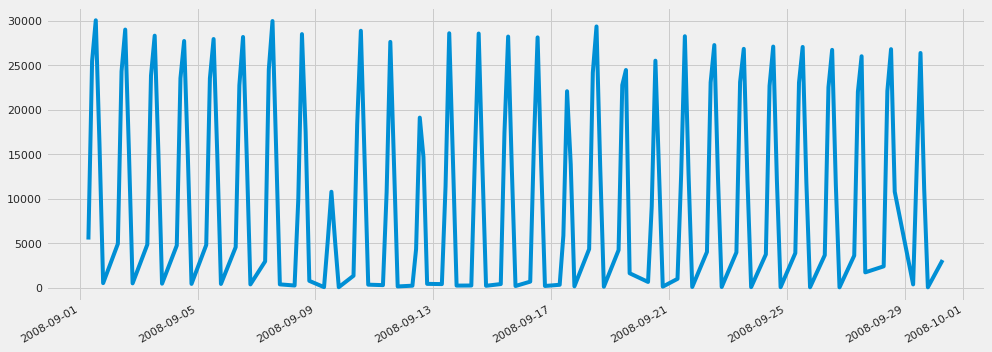

In [0]:
## Power generation vs time
plt.style.use('fivethirtyeight')
energy_weather['2008-09-01 07:00:00': '2008-09-30 07:00:00']['Power Generated'].plot(figsize=(15,6))
plt.show()

Evidently, solar energy production has a seasonality pattern, such as power will be zero at night, and reach a maximum value when sun is at a certain position. For a better understanding, I visualized this date with a method called time-series decomposition to decompose Power Generated into three distinct components: trend, seasonality, and noise

<command-12713165079493>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result_add= seasonal_decompose(energy_weather['Power Generated'], model= 'additive', extrapolate_trend='freq', freq= 365)


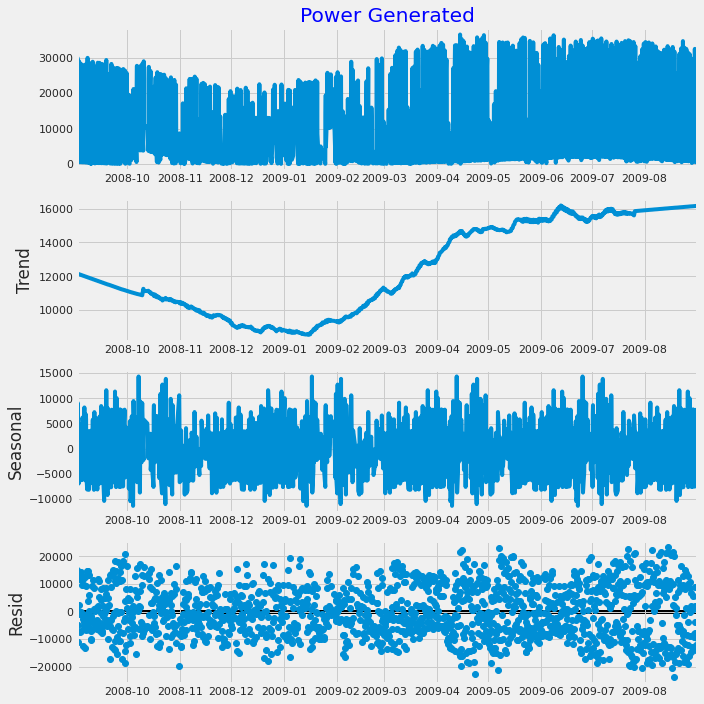

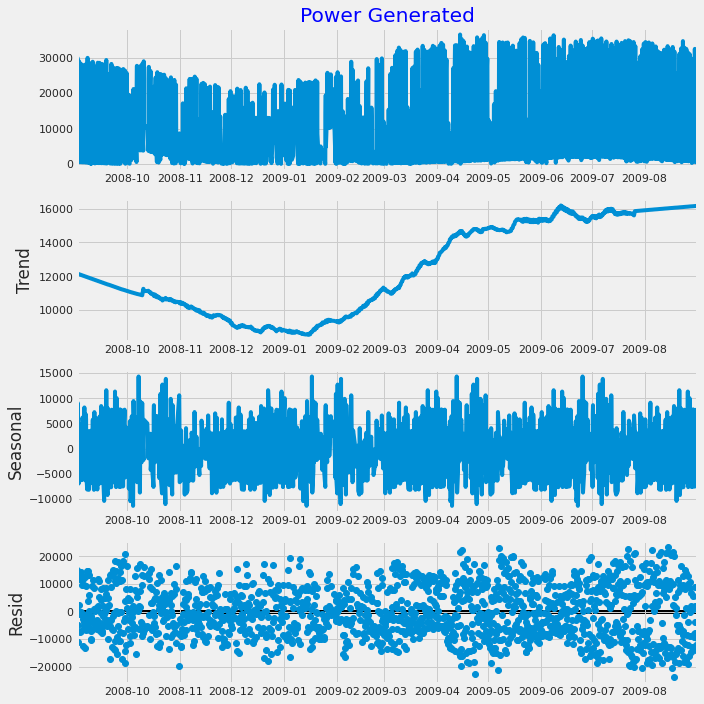

In [0]:
# Seasonality: 
result_add= seasonal_decompose(energy_weather['Power Generated'], model= 'additive', extrapolate_trend='freq', freq= 365)
plt.rcParams.update({'figure.figsize': (10,10), 'text.color':'blue'})
result_add.plot()

This plot helped me to understand the intrinsic relations with weather and solar power production. During winter months when daylight time is expected to be short, energy production trend goes downward. While, during summer, energy production is peak.

/databricks/python/lib/python3.8/site-packages/dabl/plot/supervised.py:546: FutureWarning: The second positional argument of plot is a Series 'y'. If passing a column name, use a keyword.
  warnings.warn("The second positional argument of plot is a Series 'y'."
Target looks like regression
/databricks/python/lib/python3.8/site-packages/dabl/plot/utils.py:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
Out[15]: [array([[<AxesSubplot:title={'center':'F=1.55E+04'}, xlabel='GHI', ylabel='Power Generated'>,
         <AxesSubplot:title={'center':'F=4.34E+03'}, xlabel='Solar Zenith Angle'>,
         <AxesSubplot:title={'center':'F=2.57E+03'}, xlabel='DNI'>,
         <AxesSubplot:title={'center':'F=2.47E+03'}, xlabel='Distance to Solar...'>,
         <AxesSubplot:title={'center':'F=8.88E+02'}, xlabel='Temperature'>],
        [<AxesSubplot:title={'center':'F=6.28E+02'}, xlabel='Relative Humidity_x', ylabel='Power Generated'>,
         <AxesS

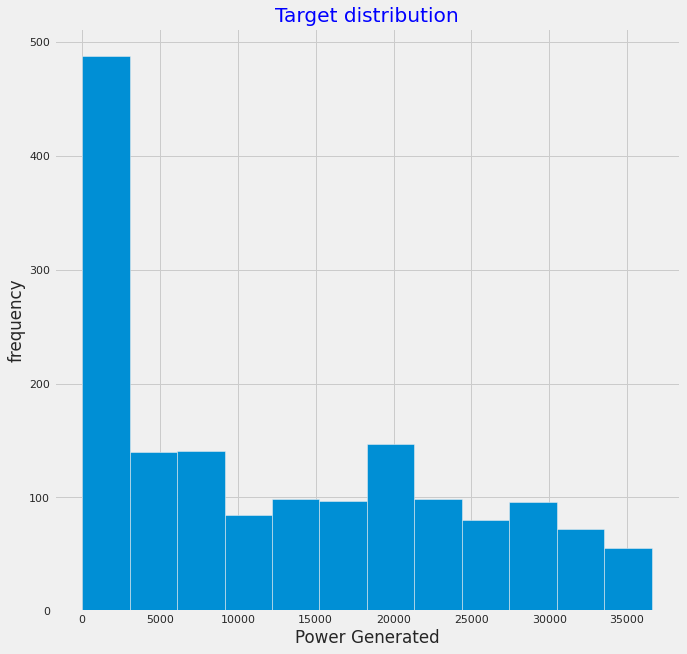

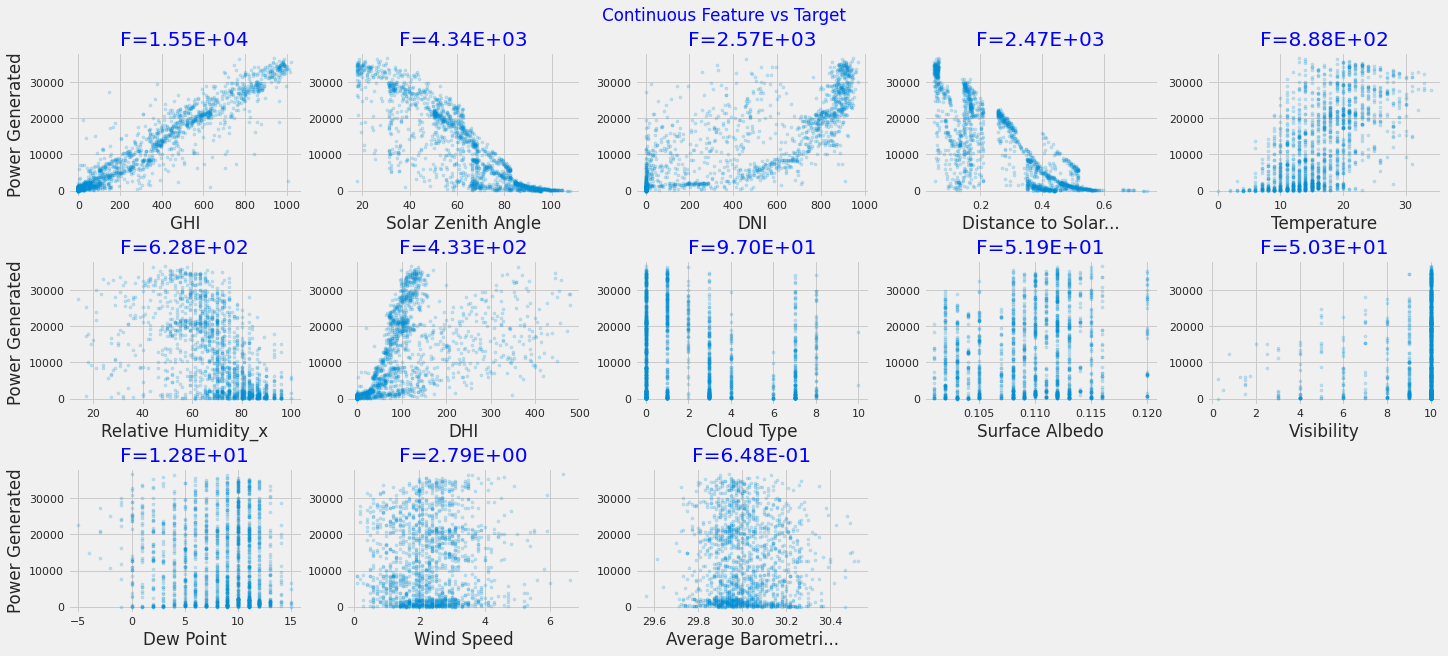

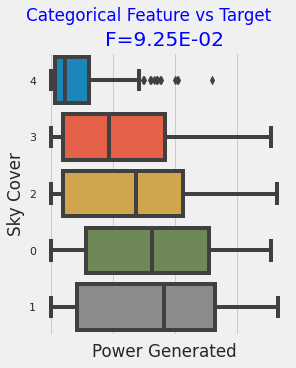

In [0]:
dabl.plot(energy_weather, 'Power Generated')

dabl is a visualization library I used to have a quick view of possible correlations of features and target in the data. There is some correlation between Power Generated and GHI, and Solar Zenith Angle. GHI variable accounts for solar irradiance and zenith angle relates to the position of the sun.

In [0]:
weather_df.columns

Out[57]: Index(['Distance to Solar Noon', 'Sky Cover', 'Visibility',
 'Relative Humidity_x', 'Average Barometric Pressure (Period)',
 'Power Generated', 'DHI', 'DNI', 'GHI', 'Cloud Type', 'Dew Point',
 'Solar Zenith Angle', 'Surface Albedo', 'Wind Speed', 'Temperature'],
 dtype='object')

/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
Out[16]: <AxesSubpl

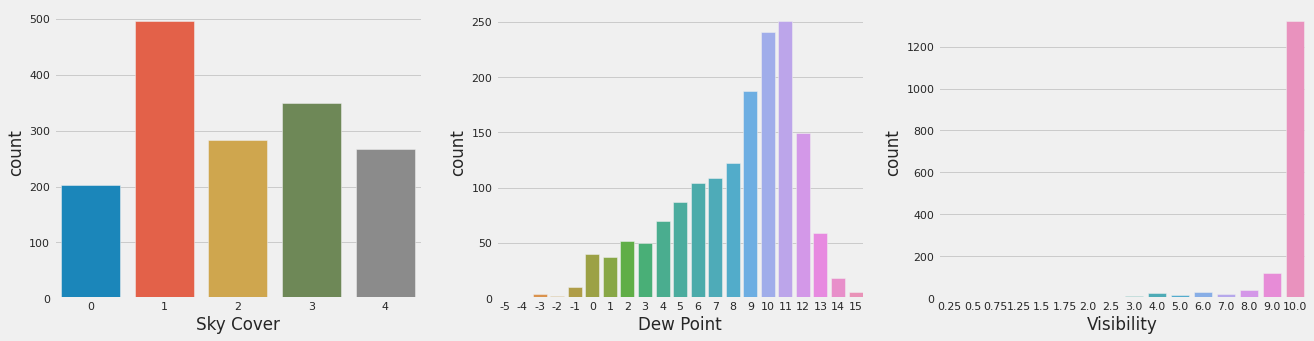

In [0]:
# Plot of categorical variables
fig, ax = plt.subplots(1,3, figsize=(20,5))

sns.countplot(energy_weather['Sky Cover'], ax=ax[0])
sns.countplot(energy_weather['Dew Point'], ax=ax[1])
sns.countplot(energy_weather['Visibility'], ax=ax[2])

I also wanted to plot categorical variables. Sky Cover is represented by a dummy variable 0-4. In general, there is more "clear days" in the data. Moreover, dew point is the atomospheric temperature below which water droplets begin to condense. Dew point follows a nearly normal distribution, but we can't tell a correlation with power generated. However, we might be able to see some correlation with visibility due to clear days means more sunlight exposure.

One important step before modeling is feature normalization. Machine learning algorithms like linear regression, logistic, and svm use gradient descent as an optimization, thus data requires to be scaled.

In [0]:
energy_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1600 entries, 2008-09-01 07:00:00 to 2009-08-31 19:00:00
Data columns (total 15 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Distance to Solar Noon                1600 non-null   float64
 1   Sky Cover                             1600 non-null   int64  
 2   Visibility                            1600 non-null   float64
 3   Relative Humidity_x                   1600 non-null   int64  
 4   Average Barometric Pressure (Period)  1600 non-null   float64
 5   Power Generated                       1600 non-null   int64  
 6   DHI                                   1600 non-null   float64
 7   DNI                                   1600 non-null   float64
 8   GHI                                   1600 non-null   float64
 9   Cloud Type                            1600 non-null   int64  
 10  Dew Point                             1600 non-n

Out[45]: Text(0.5, 1.0, 'Correlation Heatmap')

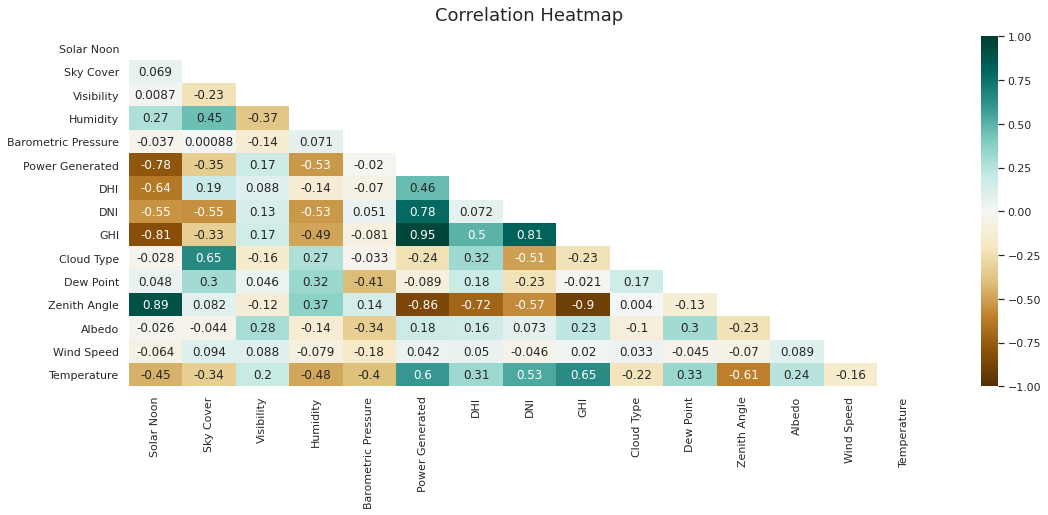

In [0]:
#_________________________Data Normalization__________
scaler = MinMaxScaler() 
to_scale = ['Distance to Solar Noon',
           'Relative Humidity_x',
           'Average Barometric Pressure (Period)',
            'DHI', 'DNI', 'GHI','Solar Zenith Angle', 
       'Surface Albedo', 'Wind Speed', 'Temperature']
energy_weather[to_scale] = scaler.fit_transform(energy_weather[to_scale])

#_________________________Columns names processing__________

energy_weather.rename(columns={'Distance to Solar Noon':'Solar Noon',
                          'Relative Humidity_x': 'Humidity',
                          'Average Barometric Pressure (Period)': 'Barometric Pressure',
                          'Solar Zenith Angle': 'Zenith Angle',
                          'Surface Albedo': 'Albedo'
                         }, inplace=True)

#_________________________Features selection__________
plt.figure(figsize=(16,6))
mask = np.triu(np.ones_like(energy_weather.corr(), dtype=bool))
heatmap = sns.heatmap(energy_weather.corr(), mask=mask, vmin=-1, vmax=1,annot= True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16)


# SPARK ML

- In this part of the notebook, I will move the dataset from pandas to spark dataframe.
- I will create a pipeline to build, evaluate and keep track of machine learning models.
- I will implement feature importance in random forest model

In [0]:
# So far, this is the dataset cleaned and arranged:
energy_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1600 entries, 2008-09-01 07:00:00 to 2009-08-31 19:00:00
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Solar Noon           1600 non-null   float64
 1   Sky Cover            1600 non-null   int64  
 2   Visibility           1600 non-null   float64
 3   Humidity             1600 non-null   float64
 4   Barometric Pressure  1600 non-null   float64
 5   Power Generated      1600 non-null   int64  
 6   DHI                  1600 non-null   float64
 7   DNI                  1600 non-null   float64
 8   GHI                  1600 non-null   float64
 9   Cloud Type           1600 non-null   int64  
 10  Dew Point            1600 non-null   int64  
 11  Zenith Angle         1600 non-null   float64
 12  Albedo               1600 non-null   float64
 13  Wind Speed           1600 non-null   float64
 14  Temperature          1600 non-null   float64
dtypes:

In [0]:
#_______________________Pandas->Spark___________________
#energy_weather = energy_weather.reset_index(drop=True)
energy_weather_spk = spark.createDataFrame(energy_weather[['Solar Noon', 'Humidity', 'DHI', 'DNI', 'GHI', 'Zenith Angle', 'Temperature', 'Power Generated']])
energy_weather_spk.cache().count()

Out[59]: 1600

In [0]:
#_______________________Split train and test_______________
(trainDF, testDF) = energy_weather_spk.randomSplit([.8, .2], seed=42)


In [0]:
testDF.coalesce(1).write.format('com.databricks.spark.csv').save('dbfs:/FileStore/shared_uploads/jgarciag@gwmail.gwu.edu/testDF.csv')

In [0]:
#TRANSFORM ALL INT AND LONG VARIABLE TYPS TO DOUBLE 
long_integer=['Day_Year', 'Year', 'Month', 'Day', 'Day_Avg_Temperature', 'Day_Avg_Wind_Direction', 'Sky Cover', 'Relative_Humidity', 'Cloud_Type', 'Dew Point']

long_double= ['Solar_Noon_Distance', 'Day_Avg_WSpeed', 'Visibility', 'Period_Avg_WSpeed', 'Period_Avg_Pressure', 'POWER', 'Diffuse_Horizontal_Irradiance','Direct_Normal_Irradiance ','Global_Horizontal_Irradiance', 'Zenith_Angle', 'Albedo']

for i in long_integer:
  train_spk_comp= train_spk_comp.withColumn(i,col(i).cast(IntegerType()))
for d in long_double:
  train_spk_comp= train_spk_comp.withColumn(d,col(d).cast(DoubleType()))

train_spk_comp= train_spk_comp.withColumn('Daylight', col('Daylight').cast(BooleanType()))


for i in long_integer:
  test_spk_comp= test_spk_comp.withColumn(i,col(i).cast(IntegerType()))
for d in long_double:
  test_spk_comp= test_spk_comp.withColumn(d,col(d).cast(DoubleType()))

test_spk_comp= test_spk_comp.withColumn('Daylight', col('Daylight').cast(BooleanType()))

- ML FLOW: Vector Assembler, Regression
  - Decision Tree
  - Random Forest
  - Linear Regression
  - Vector Assembler Regressor

# Decision Tree Regression

In [0]:
## DECISION TREE REGRESSOR ####
with mlflow.start_run(run_name='Decision-Tree') as run:
  
  features=['Solar Noon', 'Humidity', 'DHI', 'DNI', 'GHI', 'Zenith Angle', 'Temperature']
  
  #log parameters
  mlflow.log_param("label", "Decision-tree")
  
  #Define pipeline
  vecAssembler = VectorAssembler(inputCols= features, outputCol= "features")
  dt = DecisionTreeRegressor(labelCol="Power Generated")
  pipeline_dt = Pipeline(stages=[vecAssembler, dt])
  pipelineModel_dt = pipeline_dt.fit(trainDF)
  
  #Log pipelineModel: model
  mlflow.spark.log_model(pipelineModel_dt,'Decision_Tree_Pipeline')
  
  #create predictions and metrics
  #mlflow.spark.log_model(pipelineModel, "model")
  predDF_dt= pipelineModel_dt.transform(testDF)
  regressionEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Power Generated", metricName="rmse")
  rmse = regressionEvaluator.evaluate(predDF_dt)
  r2= regressionEvaluator.setMetricName('r2').evaluate(predDF_dt)
  mae= regressionEvaluator.setMetricName('mae').evaluate(predDF_dt)
  
  print(f"Decision Tree RMSE is {rmse}")
  print(f"Decision Tree R2 is {r2}")
  
  #Log metrics
  mlflow.log_metric('r2', r2)
  mlflow.log_metric('rmse',rmse)
  mlflow.log_metric('mae',mae)
  runID= run.info.run_uuid

Decision Tree RMSE is 4489.214602684426
Decision Tree R2 is 0.8378843561912495


# Random Forest Regression

In [0]:
## RANDOM FOREST REGRESSOR ####
with mlflow.start_run(run_name='Random-Forest-Regressor') as run:
  
  features=['Solar Noon', 'Humidity', 'DHI', 'DNI', 'GHI', 'Zenith Angle', 'Temperature']
  
  #log parameters
  mlflow.log_param("label", "Random-Forest")
  
  #Define pipeline
  vecAssembler = VectorAssembler(inputCols= features, outputCol= "features")
  rf = RandomForestRegressor(labelCol="Power Generated", featuresCol='features')
  pipeline_rf = Pipeline(stages=[vecAssembler, rf])
  pipelineModel_rf = pipeline_rf.fit(trainDF)
  
  #Log pipelineModel: model
  mlflow.spark.log_model(pipelineModel_rf,'Random_Forest_Pipeline')
  
  #create predictions and metrics
  #mlflow.spark.log_model(pipelineModel, "model")
  predDF_rf= pipelineModel_rf.transform(testDF)
  regressionEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Power Generated")
  rmse= regressionEvaluator.setMetricName('rmse').evaluate(predDF_rf)
  r2= regressionEvaluator.setMetricName('r2').evaluate(predDF_rf)
  mae= regressionEvaluator.setMetricName('mae').evaluate(predDF_rf)
  print(f"Random Forest RMSE is {rmse}")
  print(f"Random Forest R2 is {r2}")
  print(f"Random Forest MAE is {mae}")
  #Log metrics
  mlflow.log_metric('r2', r2)
  mlflow.log_metric('rmse',rmse)
  mlflow.log_metric('mae',mae)
  runID= run.info.run_uuid
  

Random Forest RMSE is 3608.682070406538
Random Forest R2 is 0.895243390181438
Random Forest MAE is 2196.9622636432573


# Linear Regression

In [0]:
with mlflow.start_run(run_name='Linear-regression') as run:
  
  features=['Solar Noon', 'Humidity', 'DHI', 'DNI', 'GHI', 'Zenith Angle', 'Temperature']
  
  #log parameters
  mlflow.log_param("label", "Linear Regression")
  
  #Define pipeline
  vecAssembler = VectorAssembler(inputCols= features, outputCol= "features")
  lr = LinearRegression(labelCol="Power Generated", featuresCol="features")
  pipeline_lr = Pipeline(stages=[vecAssembler, lr])
  pipelineModel_lr = pipeline_lr.fit(trainDF)
  
  #Log pipelineModel: model
  mlflow.spark.log_model(pipelineModel_lr,'Lr_Pipeline')
  
  #create predictions and metrics
  predDF_lr= pipelineModel_lr.transform(testDF)
  regressionEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Power Generated")
  rmse= regressionEvaluator.setMetricName('rmse').evaluate(predDF_lr)
  r2= regressionEvaluator.setMetricName('r2').evaluate(predDF_lr)
  mae= regressionEvaluator.setMetricName('mae').evaluate(predDF_lr)
  print(f"Linear Regression RMSE is {rmse}")
  print(f"Linear Regression R2 is {r2}")
  print(f"Linear Regression MAE is {mae}")
  #Log metrics
  mlflow.log_metric('r2', r2)
  mlflow.log_metric('rmse',rmse)
  mlflow.log_metric('mae',mae)
  runID= run.info.run_uuid
   

Linear Regression RMSE is 3875.649501016501
Linear Regression R2 is 0.8791704439237752
Linear Regression MAE is 2471.7093388212597


## Feature Importance

RMSE is 3875.649501016501
R2 is 0.8791704439237752
Out[76]: <AxesSubplot:xlabel='feature'>

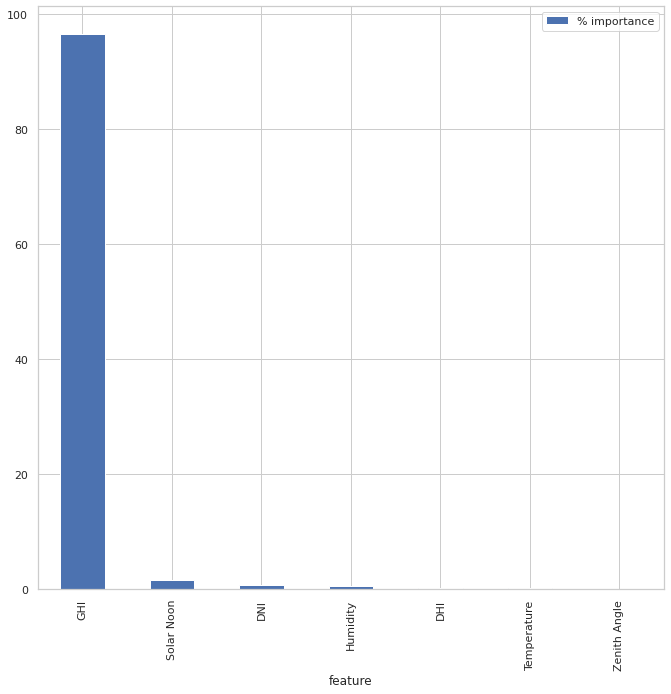

In [0]:
dtModel= pipelineModel_dt.stages[-1]
featuresDF = pd.DataFrame(list(zip(vecAssembler.getInputCols(), dtModel.featureImportances)), columns=['feature', 'importance'])
print(f"RMSE is {rmse}")
print(f"R2 is {r2}")
featuresDF['% importance']= featuresDF.importance.apply(lambda x: x*100)
topFeatures = featuresDF.sort_values(["% importance"], ascending=False)
topFeatures.plot.bar(x='feature', y='% importance')

Decision Treen visualization

In [0]:
dtModel = pipelineModel_dt.stages[-1]
display(dtModel)

treeNode
"{""index"":31,""featureType"":""continuous"",""prediction"":null,""threshold"":0.3609206660137121,""categories"":null,""feature"":4,""overflow"":false}"
"{""index"":15,""featureType"":""continuous"",""prediction"":null,""threshold"":0.16111655239960823,""categories"":null,""feature"":4,""overflow"":false}"
"{""index"":7,""featureType"":""continuous"",""prediction"":null,""threshold"":0.08863858961802154,""categories"":null,""feature"":4,""overflow"":false}"
"{""index"":3,""featureType"":""continuous"",""prediction"":null,""threshold"":0.005241090146750524,""categories"":null,""feature"":2,""overflow"":false}"
"{""index"":1,""featureType"":""continuous"",""prediction"":null,""threshold"":0.8513137385882877,""categories"":null,""feature"":5,""overflow"":false}"
"{""index"":0,""featureType"":null,""prediction"":626.9589041095891,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":2,""featureType"":null,""prediction"":257.525,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":5,""featureType"":""continuous"",""prediction"":null,""threshold"":0.6453488372093024,""categories"":null,""feature"":1,""overflow"":false}"
"{""index"":4,""featureType"":null,""prediction"":3387.3225806451615,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":6,""featureType"":null,""prediction"":1568.5344827586207,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"


## Summary of ML Experiments tracked by Spark ML Flow

In [0]:
experiment_id = run.info.experiment_id
runs_df = mlflow.search_runs(experiment_id)
#runs_df.select(col('params.label'), col('metrics.rmse'), col('metrics.mae'), col('metrics.r2')).show()
display(runs_df[['params.label','metrics.rmse','metrics.mae', 'metrics.r2' ]])
#display(runs_df)

params.label,metrics.rmse,metrics.mae,metrics.r2
Linear Regression,3875.649501016501,2471.7093388212597,0.8791704439237752
Linear Regression,3875.649501016501,2471.7093388212597,0.8791704439237752
Linear Regression,null,null,null
Random-Forest,3608.682070406538,2196.9622636432573,0.895243390181438
Decision-tree,4489.214602684426,2616.282478368065,0.8378843561912495
Decision-tree,null,null,null
Decision-tree,null,null,null
Decision-tree,null,null,null
Decision-tree,null,null,null
null,null,null,null


# MODEL OPTIMIZATION 
Spark's ParamGridBuilder to find the optimal hyperparameters:
Let's define a grid of hyperparameters to test:
  - maxDepth: max depth of the decision tree (Use the values `2, 5, 10`)
  - numTrees: number of decision trees (Use the values `10, 20, 100`)

CROSS VALIDATION
  - We are going to do 3-Fold cross-validation, with `parallelism`=4, and set the `seed`=42 on the cross-validator for reproducibility.

In [0]:
## optimization with grid search

paramGrid = (ParamGridBuilder()
            .addGrid(rf.maxDepth, [2, 5, 10])
            .addGrid(rf.numTrees,[10,20,100])
            .build())

evaluator = RegressionEvaluator(labelCol="Power Generated", predictionCol="prediction")

cv = CrossValidator(estimator=rf, evaluator= evaluator, estimatorParamMaps=paramGrid, numFolds=10, parallelism=4, seed=42 )

stages = [vecAssembler, cv]

pipeline = Pipeline(stages=stages)

pipelineModel = pipeline.fit(trainDF)

predDF_cv_dt = pipelineModel.transform(testDF)

rmse = evaluator.evaluate(predDF_cv_dt)
r2 = evaluator.setMetricName("r2").evaluate(predDF_cv_dt)
mae = evaluator.setMetricName("mae").evaluate(predDF_cv_dt)
print(f"RMSE is {rmse}")
print(f"R2 is {r2}")
print(f"MAE is {mae}")

cvModel = pipelineModel.stages[-1]
rfModel = cvModel.bestModel

list(zip(cvModel.getEstimatorParamMaps(), cvModel.avgMetrics))

print(rfModel.explainParams())





RMSE is 3469.185258457809
R2 is 0.9031857743827182
MAE is 1999.7232962207902
bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird'

In [0]:
## RANDOM FOREST REGRESSOR ####
with mlflow.start_run(run_name='Optimized-RF') as run:
  
  features=['Solar Noon', 'Humidity', 'DHI', 'DNI', 'GHI', 'Zenith Angle', 'Temperature']
  
  #log parameters
  mlflow.log_param("label", "Random-Forest")
  
  #Define pipeline
  vecAssembler = VectorAssembler(inputCols= features, outputCol= "features")
  rf_o = RandomForestRegressor(labelCol="Power Generated", 
                             featuresCol='features', 
                             maxDepth=10,
                             numTrees=100
                            )
  pipeline_rf_opt = Pipeline(stages=[vecAssembler, rf_o])
  pipelineModel_rf_opt = pipeline_rf_opt.fit(trainDF)
  
  #Log pipelineModel: model
  mlflow.spark.log_model(pipelineModel_rf_opt,'Random_Forest_Pipeline_opt')
  
  #create predictions and metrics
  #mlflow.spark.log_model(pipelineModel, "model")
  predDF_rf_op= pipelineModel_rf_opt.transform(testDF)
  regressionEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Power Generated")
  rmse= regressionEvaluator.setMetricName('rmse').evaluate(predDF_rf_op)
  r2= regressionEvaluator.setMetricName('r2').evaluate(predDF_rf_op)
  mae= regressionEvaluator.setMetricName('mae').evaluate(predDF_rf_op)
  print(f"Random Forest RMSE is {rmse}")
  print(f"Random Forest R2 is {r2}")
  print(f"Random Forest MAE is {mae}")
  #Log metrics
  mlflow.log_metric('r2', r2)
  mlflow.log_metric('rmse',rmse)
  mlflow.log_metric('mae',mae)
  runID= run.info.run_uuid
  URI = run.info.artifact_uri

Random Forest RMSE is 3469.185258457809
Random Forest R2 is 0.9031857743827182
Random Forest MAE is 1999.7232962207902


I reached .92 R2 metric with Random Forest Regression Optimized model. This metric has been achieved in non-seen Test Dataset. Moreover, Global Horizontal Irradiation is the most influential feature to predict Solar power output in this power plant. Future work includes model deployment with Spark streaming capabilities.